In [1]:
from lmfit.models import GaussianModel
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import pandas as pd

In [2]:
tds = pd.read_pickle("reduced/tds_phase_1.pkl")
tds

,time,tds_image,is_beam_on,l1_chrip_phase,charge
0,2021-02-21 00:30:17.046674013,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 4, 13, ...",True,-7.0,0.24685
1,2021-02-21 00:30:22.084268093,"[[12, 5, 4, 4, 14, 6, 0, 0, 1, 14, 9, 0, 0, 12...",False,-7.0,NaN
2,2021-02-21 00:30:25.301686049,"[[0, 12, 0, 0, 14, 0, 18, 18, 11, 0, 24, 9, 0,...",False,-7.0,NaN
3,2021-02-21 00:30:28.509352922,"[[0, 0, 3, 0, 15, 9, 0, 0, 9, 0, 22, 18, 17, 0...",False,-7.0,NaN
4,2021-02-21 00:30:31.663580894,"[[2, 0, 0, 0, 15, 11, 0, 0, 30, 0, 0, 0, 0, 11...",False,-7.0,NaN
...,...,...,...,...,...
191,2021-02-21 00:41:28.365645170,"[[0, 6, 1, 0, 17, 1, 0, 13, 0, 0, 13, 0, 0, 0,...",True,5.0,0.24900
192,2021-02-21 00:41:31.679569960,"[[0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 25, 0, 0, 0, 1...",True,5.0,0.25455
193,2021-02-21 00:41:34.964040041,"[[0, 0, 0, 0, 22, 11, 0, 0, 0, 1, 26, 0, 0, 7,...",True,5.0,0.25890
194,2021-02-21 00:41:38.410810947,"[[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,5.0,0.24915


In [3]:
background = tds.loc[1:6,"tds_image"].mean()

preprocessed = tds.loc[6:,["l1_chrip_phase","charge","tds_image"]].copy()

# Average all five images per chirp setting
preprocessed = preprocessed.groupby("l1_chrip_phase").apply(np.mean).drop("l1_chrip_phase", axis=1)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(lambda image: image.clip(0, 4095))

# Remove background
remove_background = lambda image: (image - background).clip(0, 4095)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(remove_background)

# Denoise images
def denoise(image):
    denoised = ndimage.uniform_filter(image, size=12)
    denoised[denoised < 0.05 * denoised.max()] = 0
    return denoised

preprocessed["tds_image"] = preprocessed["tds_image"].apply(denoise)

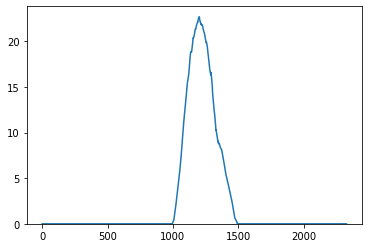

In [4]:
image = preprocessed.loc[-3.0,"tds_image"]
charge = preprocessed.loc[-3.0,"charge"] * 10e-9
seconds_per_pixel = 0.0438912 * 10e-12

ro = image.sum(axis=0)
current = charge / seconds_per_pixel * ro / ro.sum()

plt.plot(current)
plt.ylim(0, 1.05 * current.max())
plt.show()

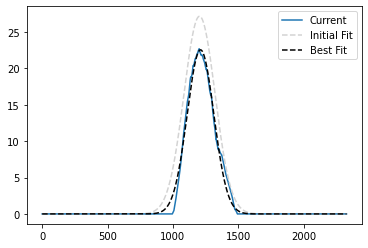

In [5]:
xs = np.arange(len(current))
model = GaussianModel()
guess = model.guess(current, x=xs)
fit = model.fit(current, guess, x=xs)

plt.plot(current, label="Current")
plt.plot(fit.init_fit, "--", c="lightgrey", label="Initial Fit")
plt.plot(fit.best_fit, "--", c="black", label="Best Fit")
plt.legend()
plt.show()

In [6]:
sigma = fit.params["sigma"].value
sigma

102.24711746407452

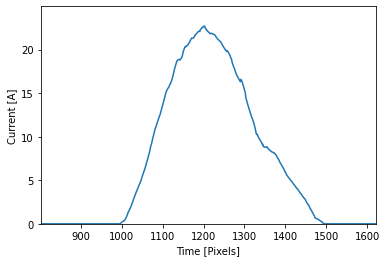

In [7]:
plt.plot(current)
plt.xlim(fit.params["center"].value-4*sigma, fit.params["center"].value+4*sigma)
plt.ylim(0, 1.1 * current.max())
plt.xlabel("Time [Pixels]")
plt.ylabel("Current [A]")
plt.show()

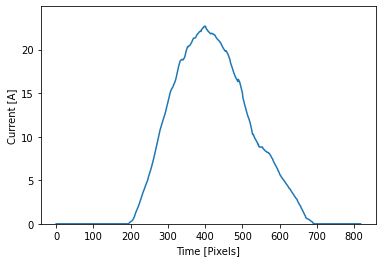

In [8]:
low = int(fit.params["center"].value-4*sigma)
high = int(fit.params["center"].value+4*sigma)
extracted = current[low:high]

plt.plot(extracted)
plt.ylim(0, 1.1 * extracted.max())
plt.xlabel("Time [Pixels]")
plt.ylabel("Current [A]")
plt.show()

In [ ]:
# Remove background noise (for example by filtering)
# ? Cut out actual beam projection

In [2]:
# Convert TDS images to bunch profiles
    # Remove background from TDS images
    # Follow Sergey's TDS image processing

In [3]:
# Get CRISP formfactors

In [4]:
# Unite bunch profiles, CRISP high and CRISP low